downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Data shape - Train: (320, 4096), Test: (80, 4096)

Training RBM 1/3 (4096-1024)
Epoch 1/15, Error: 0.1939
Epoch 2/15, Error: 0.1671
Epoch 3/15, Error: 0.1557
Epoch 4/15, Error: 0.1436
Epoch 5/15, Error: 0.1377
Epoch 6/15, Error: 0.1314
Epoch 7/15, Error: 0.1261
Epoch 8/15, Error: 0.1210
Epoch 9/15, Error: 0.1168
Epoch 10/15, Error: 0.1129
Epoch 11/15, Error: 0.1093
Epoch 12/15, Error: 0.1061
Epoch 13/15, Error: 0.1039
Epoch 14/15, Error: 0.1009
Epoch 15/15, Error: 0.0988

Training RBM 2/3 (1024-512)
Epoch 1/15, Error: 0.1090
Epoch 2/15, Error: 0.0843
Epoch 3/15, Error: 0.0745
Epoch 4/15, Error: 0.0693
Epoch 5/15, Error: 0.0638
Epoch 6/15, Error: 0.0566
Epoch 7/15, Error: 0.0512
Epoch 8/15, Error: 0.0480
Epoch 9/15, Error: 0.0452
Epoch 10/15, Error: 0.0429
Epoch 11/15, Error: 0.0403
Epoch 12/15, Error: 0.0385
Epoch 13/15, Error: 0.0363
Epoch 14/15, Error: 0.0346
Epoch 15/15, Error: 

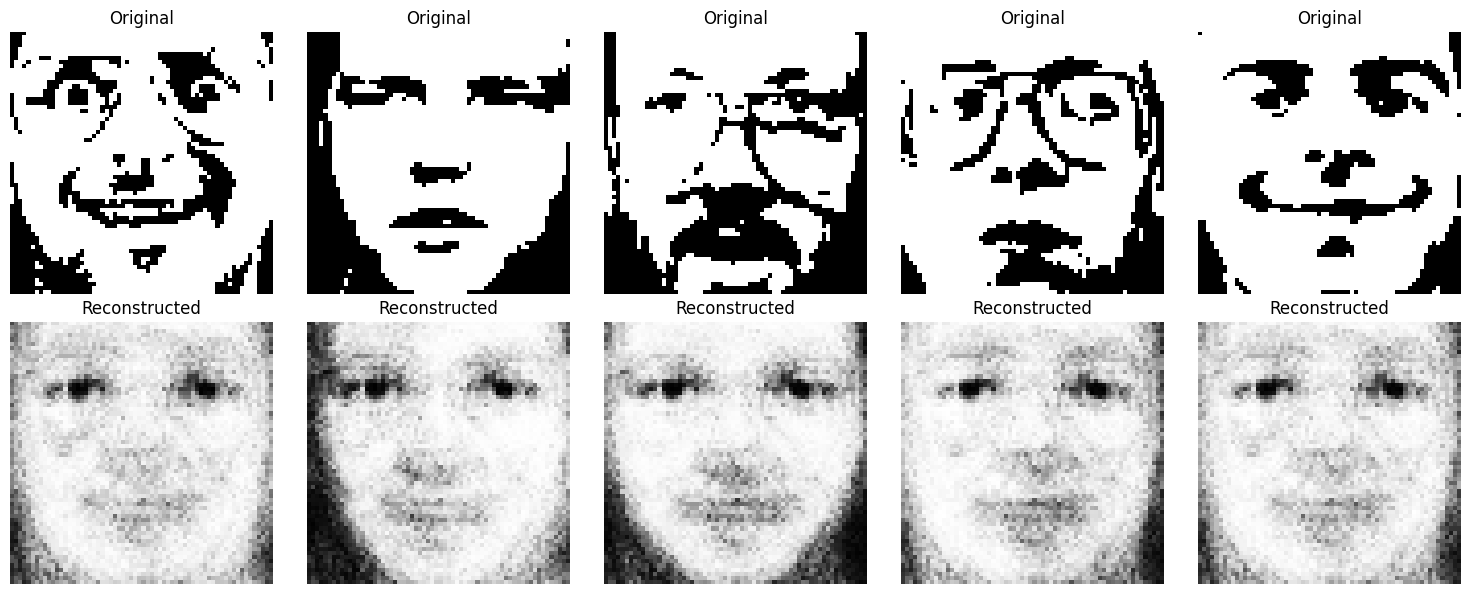

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

np.random.seed(42)

def load_data():
    faces = fetch_olivetti_faces()
    X = faces.data
    y = faces.target

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    X_train = binarize(X_train, threshold=0.5)
    X_test = binarize(X_test, threshold=0.5)

    return X_train, y_train, X_test, y_test

class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.01, k=1, epochs=20, batch_size=10):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.lr = learning_rate
        self.k = k
        self.epochs = epochs
        self.batch_size = batch_size

        self.W = np.random.normal(0, 0.01, (n_visible, n_hidden))
        self.v_bias = np.zeros(n_visible)
        self.h_bias = np.zeros(n_hidden)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample_h(self, v):
        h_prob = self.sigmoid(np.dot(v, self.W) + self.h_bias)
        return h_prob, np.random.binomial(1, h_prob)

    def sample_v(self, h):
        v_prob = self.sigmoid(np.dot(h, self.W.T) + self.v_bias)
        return v_prob, np.random.binomial(1, v_prob)

    def contrastive_divergence(self, v0):
        h0_prob, h0_sample = self.sample_h(v0)

        vk = v0.copy()
        for _ in range(self.k):
            _, hk_sample = self.sample_h(vk)
            vk_prob, vk_sample = self.sample_v(hk_sample)

        hk_prob, _ = self.sample_h(vk_sample)

        self.W += self.lr * (np.dot(v0.T, h0_prob) - np.dot(vk_sample.T, hk_prob)) / v0.shape[0]
        self.v_bias += self.lr * np.mean(v0 - vk_sample, axis=0)
        self.h_bias += self.lr * np.mean(h0_prob - hk_prob, axis=0)

        return np.mean((v0 - vk_prob) ** 2)

    def fit(self, X):
        n_samples = X.shape[0]

        for epoch in range(self.epochs):
            np.random.shuffle(X)
            errors = []

            for i in range(0, n_samples, self.batch_size):
                batch = X[i:i+self.batch_size]
                error = self.contrastive_divergence(batch)
                errors.append(error)

            print(f"Epoch {epoch+1}/{self.epochs}, Error: {np.mean(errors):.4f}")

    def transform(self, X):
        h_prob, _ = self.sample_h(X)
        return h_prob

class StackedRBM:
    def __init__(self, layer_sizes, learning_rates=None, k_list=None, epochs_list=None):
        self.layer_sizes = layer_sizes
        self.n_layers = len(layer_sizes) - 1

        if learning_rates is None:
            learning_rates = [0.01] * self.n_layers
        if k_list is None:
            k_list = [1] * self.n_layers
        if epochs_list is None:
            epochs_list = [20] * self.n_layers

        self.rbms = []
        for i in range(self.n_layers):
            rbm = RBM(n_visible=layer_sizes[i],
                      n_hidden=layer_sizes[i+1],
                      learning_rate=learning_rates[i],
                      k=k_list[i],
                      epochs=epochs_list[i])
            self.rbms.append(rbm)

    def pretrain(self, X):
        current_input = X

        for i, rbm in enumerate(self.rbms):
            print(f"\nTraining RBM {i+1}/{self.n_layers} ({rbm.n_visible}-{rbm.n_hidden})")
            rbm.fit(current_input)

            current_input = rbm.transform(current_input)

    def extract_features(self, X):
        current_input = X
        features = []

        for rbm in self.rbms:
            current_input = rbm.transform(current_input)
            features.append(current_input)

        return current_input

if __name__ == "__main__":
    X_train, y_train, X_test, y_test = load_data()
    print(f"Data shape - Train: {X_train.shape}, Test: {X_test.shape}")

    stacked_rbm = StackedRBM(layer_sizes=[4096, 1024, 512, 256],
                           learning_rates=[0.01, 0.01, 0.01],
                           epochs_list=[15, 15, 15])

    stacked_rbm.pretrain(X_train)

    train_features = stacked_rbm.extract_features(X_train)
    test_features = stacked_rbm.extract_features(X_test)
    print(f"Extracted features shape - Train: {train_features.shape}, Test: {test_features.shape}")

    clf = LogisticRegression(max_iter=1000)
    clf.fit(train_features, y_train)

    train_pred = clf.predict(train_features)
    test_pred = clf.predict(test_features)

    print(f"\nTraining accuracy: {accuracy_score(y_train, train_pred):.4f}")
    print(f"Test accuracy: {accuracy_score(y_test, test_pred):.4f}")

    def reconstruct_image(rbm, image, n_steps=10):
        v = image.copy()
        for _ in range(n_steps):
            h_prob, h_sample = rbm.sample_h(v)
            v_prob, v_sample = rbm.sample_v(h_sample)
            v = v_prob
        return v_prob

    first_rbm = stacked_rbm.rbms[0]

    sample_indices = np.random.choice(len(X_test), 5, replace=False)
    plt.figure(figsize=(15, 6))

    for i, idx in enumerate(sample_indices):
        original = X_test[idx].reshape(64, 64)
        reconstructed = reconstruct_image(first_rbm, X_test[idx]).reshape(64, 64)

        plt.subplot(2, 5, i+1)
        plt.imshow(original, cmap='gray')
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, 5, i+6)
        plt.imshow(reconstructed, cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Load LFW dataset (people with at least 70 face images)
lfw = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw.data  # shape (n_samples, 1850), flattened 62x47 grayscale images
y = lfw.target
target_names = lfw.target_names

# Normalize pixel values to [0, 1]
X = MinMaxScaler().fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- RBM class ---
class RBM(tf.keras.Model):
    def __init__(self, n_visible, n_hidden, learning_rate=0.01):
        super(RBM, self).__init__()
        self.W = tf.Variable(tf.random.normal([n_visible, n_hidden], stddev=0.01))
        self.h_bias = tf.Variable(tf.zeros([n_hidden]))
        self.v_bias = tf.Variable(tf.zeros([n_visible]))
        self.learning_rate = learning_rate

    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))

    def train_step(self, batch):
        h_prob0 = tf.nn.sigmoid(tf.matmul(batch, self.W) + self.h_bias)
        h_sample0 = self.sample_prob(h_prob0)

        v_prob1 = tf.nn.sigmoid(tf.matmul(h_sample0, tf.transpose(self.W)) + self.v_bias)
        v_sample1 = self.sample_prob(v_prob1)
        h_prob1 = tf.nn.sigmoid(tf.matmul(v_sample1, self.W) + self.h_bias)

        positive_grad = tf.matmul(tf.transpose(batch), h_prob0)
        negative_grad = tf.matmul(tf.transpose(v_sample1), h_prob1)

        grad_W = (positive_grad - negative_grad) / tf.cast(tf.shape(batch)[0], tf.float32)
        grad_vb = tf.reduce_mean(batch - v_sample1, axis=0)
        grad_hb = tf.reduce_mean(h_prob0 - h_prob1, axis=0)

        self.W.assign_add(self.learning_rate * grad_W)
        self.v_bias.assign_add(self.learning_rate * grad_vb)
        self.h_bias.assign_add(self.learning_rate * grad_hb)

        loss = tf.reduce_mean(tf.square(batch - v_prob1))
        return loss

    def transform(self, X):
        return tf.nn.sigmoid(tf.matmul(X, self.W) + self.h_bias)

# --- DBN class ---
class DBN:
    def __init__(self, layer_sizes, learning_rate=0.01):
        self.rbms = []
        for i in range(len(layer_sizes) - 1):
            self.rbms.append(RBM(layer_sizes[i], layer_sizes[i+1], learning_rate))

    def pretrain(self, X, batch_size=32, epochs=10):
        input_data = X
        for i, rbm in enumerate(self.rbms):
            print(f"\nTraining RBM Layer {i+1}")
            for epoch in range(epochs):
                perm = np.random.permutation(len(input_data))
                losses = []
                for j in range(0, len(input_data), batch_size):
                    batch = input_data[perm[j:j+batch_size]]
                    batch = tf.convert_to_tensor(batch, dtype=tf.float32)
                    loss = rbm.train_step(batch)
                    losses.append(loss.numpy())
                print(f"  Epoch {epoch+1}: Loss = {np.mean(losses):.4f}")
            input_data = rbm.transform(tf.convert_to_tensor(input_data, dtype=tf.float32)).numpy()

    def transform(self, X):
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        for rbm in self.rbms:
            X = rbm.transform(X)
        return X

# --- Run everything ---
if __name__ == "__main__":
    input_dim = X.shape[1]  # 1850 pixels
    dbn = DBN([input_dim, 512, 128], learning_rate=0.01)
    dbn.pretrain(X_train, epochs=10)

    # Extract features
    X_train_transformed = dbn.transform(X_train).numpy()
    X_test_transformed = dbn.transform(X_test).numpy()

    # Train classifier
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_transformed, y_train)
    y_pred = clf.predict(X_test_transformed)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))



Training RBM Layer 1
  Epoch 1: Loss = 0.0302
  Epoch 2: Loss = 0.0284
  Epoch 3: Loss = 0.0279
  Epoch 4: Loss = 0.0273
  Epoch 5: Loss = 0.0269
  Epoch 6: Loss = 0.0265
  Epoch 7: Loss = 0.0260
  Epoch 8: Loss = 0.0252
  Epoch 9: Loss = 0.0244
  Epoch 10: Loss = 0.0239

Training RBM Layer 2
  Epoch 1: Loss = 0.0475
  Epoch 2: Loss = 0.0079
  Epoch 3: Loss = 0.0074
  Epoch 4: Loss = 0.0073
  Epoch 5: Loss = 0.0071
  Epoch 6: Loss = 0.0070
  Epoch 7: Loss = 0.0070
  Epoch 8: Loss = 0.0070
  Epoch 9: Loss = 0.0069
  Epoch 10: Loss = 0.0070

Classification Report:
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        11
     Colin Powell       0.29      0.04      0.07        47
  Donald Rumsfeld       0.00      0.00      0.00        22
    George W Bush       0.47      0.98      0.63       119
Gerhard Schroeder       0.00      0.00      0.00        19
      Hugo Chavez       0.00      0.00      0.00        13
       Tony Blai

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
